# Sensitivity analysis

In [1]:
import glob
import os
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from h2ss import compare

In [2]:
cavern_diameter = np.arange(80, 101, step=1)
cavern_height = np.arange(85, 312, step=1)

In [3]:
def generate_sensitivity_data(cavern_diameter, cavern_height):
    """Generate data to perform sensitivity analysis"""
    os.makedirs("data", "sensitivity", exist_ok=True)
    ds, extent, exclusions = compare.load_all_data()
    for d, h in product(cavern_diameter, cavern_height):
        df = compare.capacity_function(ds, extent, exclusions, d, h)
        df.to_csv(
            os.path.join("data", "sensitivity", f"sensitivity_d{d}_h{h}.csv")
        )
        print(f"sensitivity_d{d}_h{h}.csv done!")

In [4]:
# generate_sensitivity_data(cavern_diameter, cavern_height)

In [5]:
len(list(product(cavern_diameter, cavern_height)))

4767

In [6]:
len(glob.glob(os.path.join("data", "sensitivity", f"sensitivity_*.csv")))

4767

In [7]:
df = pd.concat(
    (
        pd.read_csv(f)
        for f in glob.glob(
            os.path.join("data", "sensitivity", f"sensitivity_*.csv")
        )
    ),
    ignore_index=True,
)

In [8]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [9]:
df["cavern_height"] = df["cavern_height"].astype(int)

In [10]:
df.describe()

,cavern_diameter,cavern_height,capacity
count,411526.000000,411526.000000,411526.000000
mean,89.058592,134.444152,136.861511
std,6.035555,46.248625,65.457658
min,80.000000,85.000000,32.603093
25%,84.000000,100.000000,88.295325
50%,89.000000,120.000000,121.183718
75%,94.000000,155.000000,171.652434
max,100.000000,311.000000,500.575182


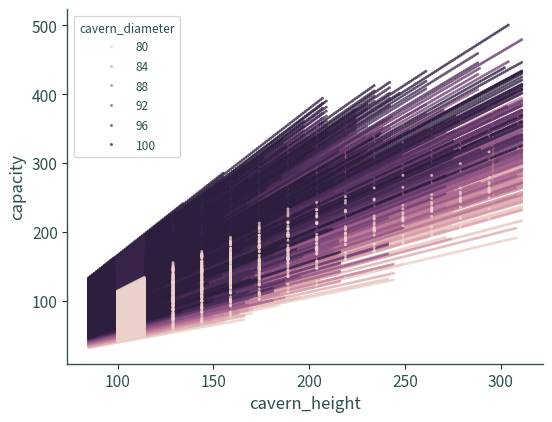

In [11]:
ax = sns.scatterplot(
    data=df,
    hue="cavern_diameter",
    y="capacity",
    x="cavern_height",
    linewidth=0,
    alpha=0.75,
    s=5,
)
sns.despine()
plt.show()

## Mean capacity

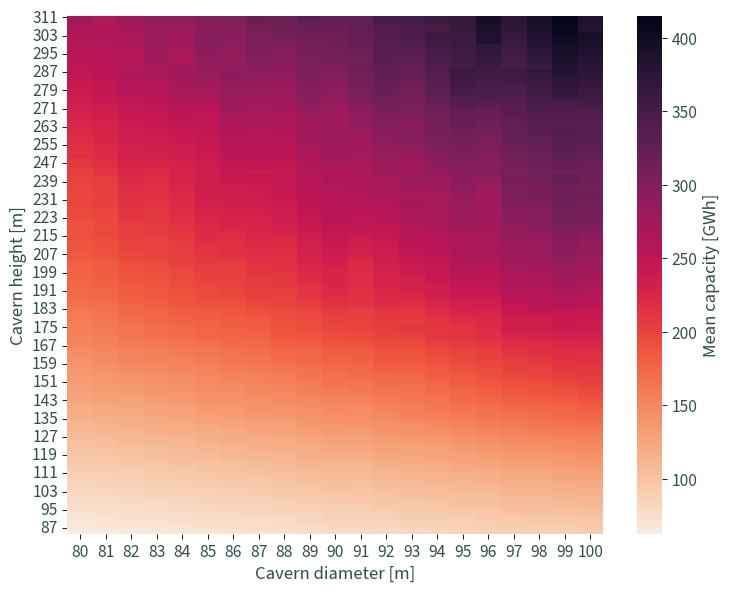

In [12]:
data = df.groupby(["cavern_height", "cavern_diameter"]).mean().reset_index().pivot(index="cavern_height", columns="cavern_diameter", values="capacity").sort_index(ascending=False)
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(data, ax=ax, cmap="rocket_r", cbar_kws={"label": "Mean capacity [GWh]"},)
ax.set_xlabel("Cavern diameter [m]")
ax.set_ylabel("Cavern height [m]")
plt.show()

## Total capacity

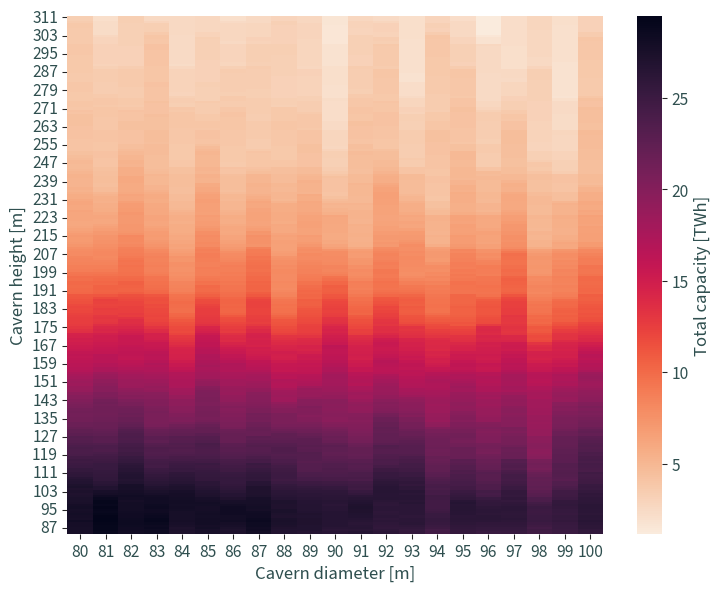

In [13]:
data = df.copy()
data["capacity"] = data["capacity"] / 1000
data = data.groupby(["cavern_height", "cavern_diameter"]).sum().reset_index().pivot(index="cavern_height", columns="cavern_diameter", values="capacity").sort_index(ascending=False)
f, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(data, ax=ax, cmap="rocket_r", cbar_kws={"label": "Total capacity [TWh]"})
ax.set_xlabel("Cavern diameter [m]")
ax.set_ylabel("Cavern height [m]")
plt.show()

## Base case

In [14]:
base = df[
    (df["cavern_diameter"] == 85) & (df["cavern_height"] == 120)
].reset_index(drop=True)

In [15]:
base.describe()[["capacity"]]

,capacity
count,218.000000
mean,108.634041
std,25.946851
min,55.946359
25%,89.482842
50%,109.211632
75%,129.493525
max,158.798899


In [16]:
base_mean = base[["capacity"]].mean().values[0]

In [17]:
base_sum = base[["capacity"]].sum().values[0]

In [18]:
print(f"{base_sum:.3f}")

23682.221


## Base diameter, varying height

In [19]:
dd = df[(df["cavern_diameter"] == 85)].reset_index(drop=True)

In [20]:
dd_mean = (
    pd.DataFrame(dd.groupby("cavern_height").mean()["capacity"] - base_mean)
    / base_mean
    * 100
).reset_index()

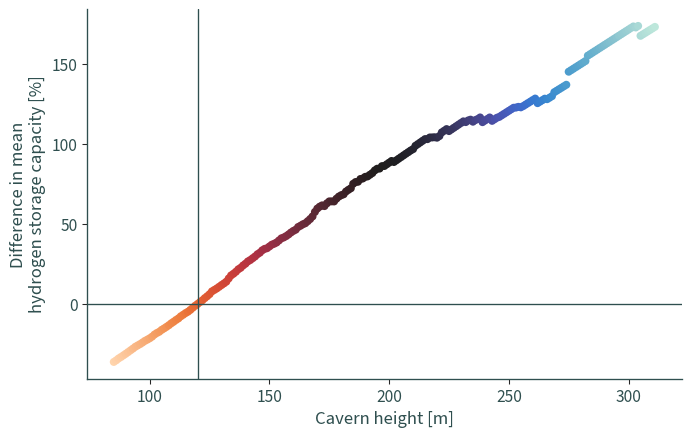

In [21]:
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(
    data=dd_mean,
    hue="cavern_height",
    y="capacity",
    x="cavern_height",
    palette="icefire_r",
    legend=False,
    linewidth=0,
)
ax.axhline(0, color="darkslategrey", linewidth=1)
ax.axvline(120, color="darkslategrey", linewidth=1)
ax.set_xlabel("Cavern height [m]")
ax.set_ylabel("Difference in mean\nhydrogen storage capacity [%]")
sns.despine()
plt.show()

In [22]:
dd_sum = (
    pd.DataFrame(dd.groupby("cavern_height").sum()["capacity"] - base_sum)
    / base_sum
    * 100
).reset_index()

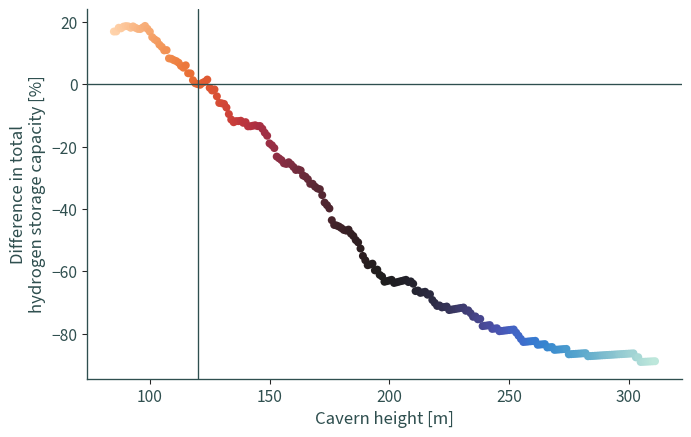

In [23]:
plt.figure(figsize=(8, 5))
ax = sns.scatterplot(
    data=dd_sum,
    hue="cavern_height",
    y="capacity",
    x="cavern_height",
    palette="icefire_r",
    legend=False,
    linewidth=0,
)
ax.axhline(0, color="darkslategrey", linewidth=1)
ax.axvline(120, color="darkslategrey", linewidth=1)
ax.set_xlabel("Cavern height [m]")
ax.set_ylabel("Difference in total\nhydrogen storage capacity [%]")
sns.despine()
plt.show()

## Base height, varying diameter

In [24]:
dh = df[(df["cavern_height"] == 120)].reset_index(drop=True)

In [25]:
dh_mean = (
    pd.DataFrame(dh.groupby("cavern_diameter").mean()["capacity"] - base_mean)
    / base_mean
    * 100
).reset_index()

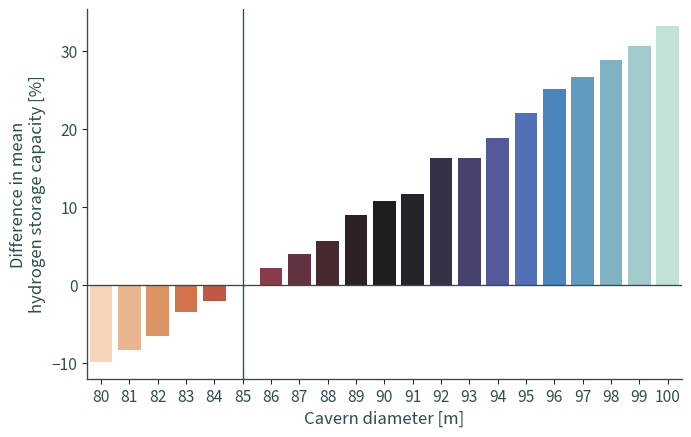

In [26]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=dh_mean,
    hue="cavern_diameter",
    y="capacity",
    x="cavern_diameter",
    palette="icefire_r",
    legend=False,
)
ax.axhline(0, color="darkslategrey", linewidth=1)
ax.axvline("85", color="darkslategrey", linewidth=1)
ax.set_xlabel("Cavern diameter [m]")
ax.set_ylabel("Difference in mean\nhydrogen storage capacity [%]")
sns.despine()
plt.show()

In [27]:
dh_sum = (
    pd.DataFrame(dh.groupby("cavern_diameter").sum()["capacity"] - base_sum)
    / base_sum
    * 100
).reset_index()

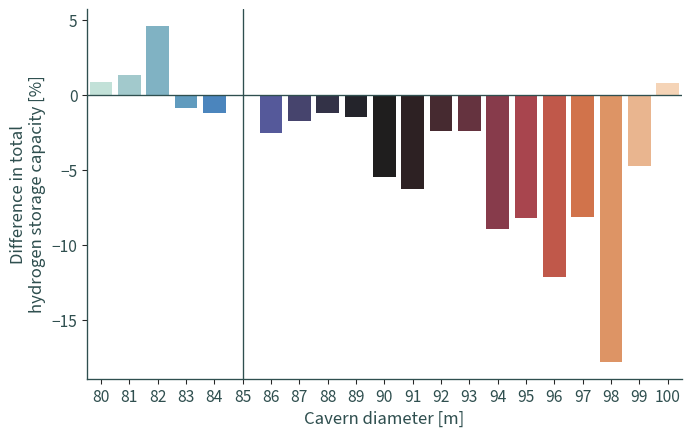

In [28]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=dh_sum,
    hue="cavern_diameter",
    y="capacity",
    x="cavern_diameter",
    palette="icefire",
    legend=False,
)
ax.axhline(0, color="darkslategrey", linewidth=1)
ax.axvline("85", color="darkslategrey", linewidth=1)
ax.set_xlabel("Cavern diameter [m]")
ax.set_ylabel("Difference in total\nhydrogen storage capacity [%]")
sns.despine()
plt.show()

## Combined plots

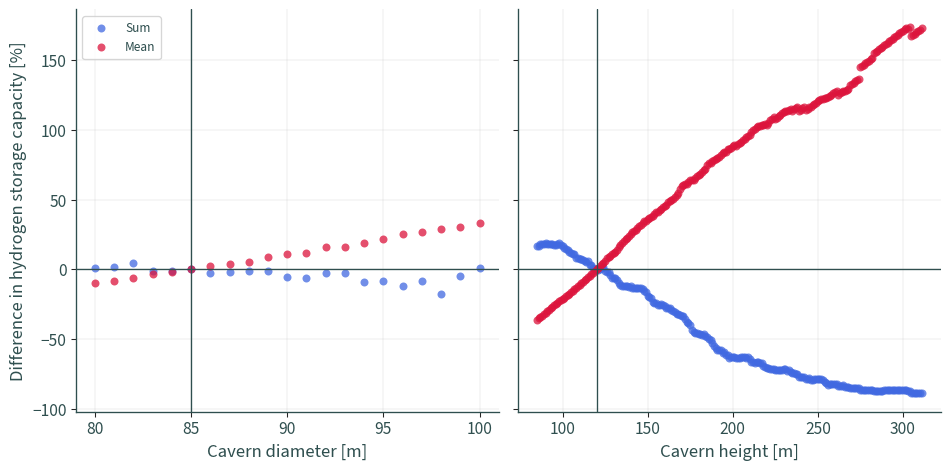

In [37]:
f, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.scatterplot(
    data=dh_sum,
    y="capacity",
    x="cavern_diameter",
    linewidth=0,
    alpha=.75,
    label="Sum",
    color="royalblue",
    ax=ax[0],
)
sns.scatterplot(
    data=dh_mean,
    y="capacity",
    x="cavern_diameter",
    ax=ax[0],
    linewidth=0,
    alpha=.75,
    label="Mean",
    color="crimson"
)
sns.scatterplot(
    data=dd_sum,
    y="capacity",
    x="cavern_height",
    linewidth=0,
    alpha=.75,
    color="royalblue",
    ax=ax[1]
)
sns.scatterplot(
    data=dd_mean,
    y="capacity",
    x="cavern_height",
    ax=ax[1],
    linewidth=0,
    alpha=.75,
    color="crimson",
)
for a in ax.flat:
    a.axhline(0, color="darkslategrey", linewidth=1)
    a.xaxis.grid(True, linewidth=0.25)
    a.yaxis.grid(True, linewidth=0.25)
ax[0].axvline(85, color="darkslategrey", linewidth=1)
ax[1].axvline(120, color="darkslategrey", linewidth=1)
ax[0].set_xlabel("Cavern diameter [m]")
ax[1].set_xlabel("Cavern height [m]")
ax[0].set_ylabel("Difference in hydrogen storage capacity [%]")
ax[0].legend(loc="upper left")
sns.despine()
plt.tight_layout()
plt.savefig(
    os.path.join("graphics", f"fig_sensitivity.jpg"),
    format="jpg",
    dpi=600,
)
plt.show()